HHU Deep Learning, WS2023/24, 20.20.2023

Lecture: Prof. Dr. Markus Kollmann

Exercises: Nikolas Adaloglou, Felix Michels

# Assignment 10 - Cityscapes Image Segmentation with a U-Net

---

Submit the solved notebook (not a zip) with your full name plus assingment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. If we feel like you have genuinely tried to solve the exercise, you will receive 1 point for this assignment, regardless of the quality of your solution.

## <center> DUE FRIDAY 12.01.2024 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/1p7L30VTOH1Wkmy](https://uni-duesseldorf.sciebo.de/s/1p7L30VTOH1Wkmy)

---

## Part I. Preparation

For this exercise you need to install `torchmetrics`.

In [12]:
!pip install torchmetrics
!pip install torchsummary

In [13]:
!wget -c https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a10_unet/data.tar.gz
!tar xf data.tar.gz

--2023-12-20 11:05:16--  https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a10_unet/data.tar.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HHU-MMBS/Deep-Learning-Exercise-Extras/main/a10_unet/data.tar.gz [following]
--2023-12-20 11:05:16--  https://raw.githubusercontent.com/HHU-MMBS/Deep-Learning-Exercise-Extras/main/a10_unet/data.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [14]:
import os
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.nn.functional import relu
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

from torchmetrics.classification import MulticlassJaccardIndex as iou

from utils import *
from torchsummary import summary

ignore_index=250

%load_ext autoreload

%autoreload 2
os.makedirs("./figs/", exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part II. U-Net Implementation

The first part of this exercise is about implementing the U-Net architecture in a practical and flexible way. You will implement the U-Net via 3 classes:

- `Conv2d`: An extension of the nn.Conv2d class with additional functionality for our U-Net.
- `UNetBlock`: A block with different layers of fixed spatial resolution. This is the building block of our U-Net and uses the Conv2d class.
- `UNet`: The complete model, using `UNetBlock` to piece together the architecture.

Your final U-Net model should have the following features:

- Variable kernel size
- Variable model width (number of channels in each conv layer)
- Variable model depth (number of feature resolution levels and number of `UNetBlock`s per level)
- Optional dropout regularization

Below is an illustration of a U-Net architecture for medical image segmentation with 5 resolution levels.

![u-net-architecture.png](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a10_unet/figs/u-net-architecture.png)
<center> <b> Figure: </b> Classical U-Net architecture from the original <a href="https://arxiv.org/abs/1505.04597" title="paper"> paper. </a>  </center>

**Task:** Implement the `Conv2d` class below, which fullfills 3 functions:

- **Regular case:** This class becomes a regular `nn.Conv2d` layer using its argument for `kernel`.
- **Down-sampling case:** This class becomes a series of a `nn.MaxPool2d` with `kernel_size=2` and a `nn.Conv2d` layer using `kernel_size=3`.
- **Up-sampling case:** This class becomes a series of an `nn.Upsample` layer with `scale_factor=2`, `mode='bilinear'` and `align_corners=True`, and a `nn.Conv2d` layer using `kernel_size=3`.

**Optional** (See Part VIII for details)
- If `pooling=False` use strided convlution instead of max pooling.
- If `bilinear=False` use transposed convolution instead of bilinear upsamling.

For all cases set padding such that the output height and width stay the same or change by factor of two (or one half).
Also, use the appropriate number of `in_channels`, `out_channels` and pass the `bias` argument.

In [15]:
class Conv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel=0, bias=True,
                    up=False, down=False, pooling=True, bilinear=True):
        """
        Args:
            in_channels:        Number of input channels for this block.
            out_channels:       Number of output channels for this block.
            kernel:             Kernel size for the first convolution.
            bias:               Bias parameter for the convolution.
            up/down:            Whether the first convolution is in up- or down-sampling mode.
        """
        super().__init__()
        assert not (up and down), 'up and down cannot be both True'
        assert not (kernel and (up or down)), 'Cannot use kernel with up/down sampling'
        assert kernel or up or down, 'Must use kernel or up or down sampling'
        ### START CODE HERE ### (approx. 10 lines)
        conv_kwargs = dict(
            in_channels=in_channels,
            out_channels=out_channels,
            bias=bias
        )
        self.resize = nn.Identity()
        conv_type = nn.Conv2d
        # Down-sampling case
        if down:
            conv_kwargs.update(kernel_size=3, padding=1)
            if pooling:
                self.resize = nn.MaxPool2d(2)
            else:
                conv_kwargs['stride'] = 2
        # Up-sampling case
        elif up:
            if bilinear:
                self.resize = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                conv_kwargs.update(kernel_size=3, padding=1)
            else:
                conv_kwargs.update(kernel_size=2, stride=2)
                conv_type = nn.ConvTranspose2d
        elif kernel:
            conv_kwargs.update(kernel_size=kernel, padding=kernel // 2)
        self.conv = conv_type(**conv_kwargs)
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (approx. 2 lines)
        return self.conv(self.resize(x))
        ### END CODE HERE ###

In [16]:
def test_conv2d():
    x = torch.zeros(16, 64, 100, 100)
    convs = [Conv2d(64, 1, 3), Conv2d(64, 1, down=True), Conv2d(64, 1, down=True), Conv2d(64, 1, up=True), Conv2d(64, 1, up=True)]
    for conv in convs:
        print(f'Output shape: {conv(x).shape}.')

test_conv2d()

Output shape: torch.Size([16, 1, 100, 100]).
Output shape: torch.Size([16, 1, 50, 50]).
Output shape: torch.Size([16, 1, 50, 50]).
Output shape: torch.Size([16, 1, 200, 200]).
Output shape: torch.Size([16, 1, 200, 200]).


### Expected result
```
Output shape: torch.Size([16, 1, 100, 100]).
Output shape: torch.Size([16, 1, 50, 50]).
Output shape: torch.Size([16, 1, 50, 50]).
Output shape: torch.Size([16, 1, 200, 200]).
Output shape: torch.Size([16, 1, 200, 200]).
```

**Task:** Implement the `UNetBlock` class below. Make sure to read to docstring for more information on the arguemnts. One block has the following structure:

1. Copy the input for a potential residual connection.
2. BatchNorm2d -> ReLU activation -> Conv2d with potential down-/up-sampling.
3. BatchNorm2d -> ReLU activation -> optional dropout -> Conv2d with kernel_size 3.
4. Add the residual connection here, if the shape of x didn't change in the convolutions.

In [17]:
class UNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel=0, up=False, down=False,
                         dropout=0, eps=1e-5, bilinear=True, pooling=True):
        """
        Args:
            in_channels:        Number of input channels for this block.
            out_channels:       Number of output channels for this block.
            kernel:             Kernel size for the first convolution.
            up/down:            Whether the first convolution is in up- or down-sampling mode.
            dropout:            Dropout probability for dropout before the second conv.
            eps:                Epsilon parameter for BatchNorm2d.
        """
        super().__init__()
        ### START CODE HERE ### (approx. 5 lines)
        self.norm0 = nn.BatchNorm2d(in_channels, eps)
        self.conv0 = Conv2d(in_channels, out_channels, kernel,
                            up=up, down=down,
                            bilinear=bilinear, pooling=pooling)
        self.norm1 = nn.BatchNorm2d(out_channels, eps)
        self.conv1 = Conv2d(out_channels, out_channels, 3)
        self.dropout = dropout
        self.out_channels = out_channels

        self.res = not (out_channels != in_channels or up or down)
        ### END CODE HERE ###


    def forward(self, x):
        ### START CODE HERE ### (approx. 6 lines)
        orig = x
        x = self.conv0(relu(self.norm0(x)))  # in-conv
        x = relu(self.norm1(x))
        x = self.conv1(torch.nn.functional.dropout(x, p=self.dropout, training=self.training))  # optional dropout
        if self.res:
            x = x + orig  # optional residual connection
        ### END CODE HERE ###
        return x

In [18]:
def test_unet_block():
    x = torch.zeros(16, 64, 100, 100)
    blocks = [UNetBlock(64, 1, 3, dropout=0.1), UNetBlock(64, 1, down=True), UNetBlock(64, 1, down=True), UNetBlock(64, 1, up=True), UNetBlock(64, 1, up=True)]
    for block in blocks:
        print(f'Output shape: {block(x).shape}.')

test_unet_block()

Output shape: torch.Size([16, 1, 100, 100]).
Output shape: torch.Size([16, 1, 50, 50]).
Output shape: torch.Size([16, 1, 50, 50]).
Output shape: torch.Size([16, 1, 200, 200]).
Output shape: torch.Size([16, 1, 200, 200]).


### Expected result
```
Output shape: torch.Size([16, 1, 100, 100]).
Output shape: torch.Size([16, 1, 50, 50]).
Output shape: torch.Size([16, 1, 50, 50]).
Output shape: torch.Size([16, 1, 200, 200]).
Output shape: torch.Size([16, 1, 200, 200]).
```

**Task:** Now, armed with the `Conv2d` and `UNetBlock` classes, we can build the whole architecture. Use the illustration above the help you here. Tips and requirements for the implementation:

- **Encoder-Decoder architecture:** Implement the encoder and decoder separately. Each of them loop through the resolution levels. The variable `channel_mult` specifies the number of levels, i.e. `[1, 2, 4]` would be 3 levels with channel multipliers 1, 2 and 4 respectively.
- **Variable model width.** The `in_channels` and `out_channels` of every layer are a multiple of the `base_channels`. The multiple is specified in the `channel_mult` variable for each level. The only execeptions are the very first and very last layer (layer != level).
- **Variable model depth.** This U-Net contains `len(channel_mult)` levels with `num_blocks` `UNetBlock`s each.
- **At the beginning of every level**, there is either a down-sample or up-sample `UNetBlock`, with two exceptions. In the first level (level 0) of the encoder there is a `Conv2d` with kernel size `kernel` and no dropout instead. In the first level of the decoder (level len(channel_mult) - 1) there are two bottleneck layers, which are two `UNetBlock`s with kernel size `kernel`.
- **At the very end of the model**, apply a `BatchNorm2d` layer, a ReLU activation and a `Conv2d` with kernel size 3 and no dropout.
- **Skip connections:** Save the output of the last `UNetBlock` in each level in the encoder and concatenate it to the input of the first `UNetBlock` (though not the up-sample blocks) in each level in the decoder.

Tips:

- Check out `torch.nn.ModuleDict`. This lets you collect a number of named layers in the init and iterate through them in the forward, since this dictionary respects order of insertion. The fact that each layers gets a custom name here makes it easy to initialize them in a loop, using the indices of a loop over levels and a loop over `num_blocks` for the layer name. Additionally, you can do neat things like:

```
if 'block0' in name:  # First UNetBlock in each level
    x = torch.cat([x, skips.pop()], dim=1)
```

in order to locate which blocks output/receive skip-connections.

Make sure that your model works for different choices of `base_channels`, `channel_mult` and `num_blocks`. The only constraint here is that the maximum number of levels is 7, since our input height and width is 7 times divisible by 2.

In [19]:
class UNet(torch.nn.Module):
    def __init__(self, resolution, in_channels, out_channels, kernel_size=3, base_channels=32, channel_mult=[1,2,4], num_blocks=1, dropout=0.10,
                 pooling=True, bilinear=True):
        """
        Args:
            resolution:     Image resolution at input/output.
            in_channels:    Number of color channels at input.
            out_channels:   Number of color channels at output.
            kernel_size:    Convolution kernel size.
            base_channels:  Base multiplier for the number of channels.
            channel_mult:   Per-resolution multipliers for the number of channels.
            num_blocks:     Number of residual blocks per resolution.
            dropout:        Dropout probability of intermediate activations.
        """
        super().__init__()
        ### START CODE HERE ### (approx. 32 lines)
        self.in_channels = in_channels
        self.num_blocks = num_blocks
        # Encoder.
        self.enc = torch.nn.ModuleDict()
        cout = in_channels
        for level, mult in enumerate(channel_mult):
            res = resolution >> level  # really nice way of computing the resolution at each level
            if level == 0:
                cin = cout
                cout = base_channels
                self.enc[f'{res}x{res}_in_conv'] = Conv2d(in_channels=cin, out_channels=cout, kernel=kernel_size)
            else:
                self.enc[f'{res}x{res}_down'] = UNetBlock(in_channels=cout, out_channels=cout, down=True, dropout=dropout, pooling=pooling)
            for idx in range(num_blocks):
                cin = cout
                cout = base_channels * mult
                self.enc[f'{res}x{res}_block{idx}'] = UNetBlock(in_channels=cin, out_channels=cout, kernel=kernel_size, dropout=dropout)
        skips = [block.out_channels for name, block in self.enc.items() if f'block{num_blocks-1}' in name]  # Last UNetBlock in each level

        # Decoder.
        self.dec = torch.nn.ModuleDict()
        for level, mult in reversed(list(enumerate(channel_mult))):
            res = resolution >> level
            if level == len(channel_mult) - 1:
                self.dec[f'{res}x{res}_bottleneck0'] = UNetBlock(in_channels=cout, out_channels=cout, kernel=kernel_size, dropout=dropout)
                self.dec[f'{res}x{res}_bottleneck1'] = UNetBlock(in_channels=cout, out_channels=cout, kernel=kernel_size, dropout=dropout)
            else:
                self.dec[f'{res}x{res}_up'] = UNetBlock(in_channels=cout, out_channels=cout, up=True, dropout=dropout, bilinear=bilinear)
            for idx in range(num_blocks):
                cin = cout if idx != 0 else cout + skips.pop()  # First UNetBlock in each level
                cout = base_channels * mult
                self.dec[f'{res}x{res}_block{idx}'] = UNetBlock(in_channels=cin, out_channels=cout, kernel=kernel_size, dropout=dropout)
            if level == 0:
                self.dec[f'{res}x{res}_out_norm'] = nn.BatchNorm2d(num_features=cout, eps=1e-6)
                self.dec[f'{res}x{res}_out_conv'] = nn.Sequential(nn.ReLU(), Conv2d(in_channels=cout, out_channels=out_channels, kernel=3))
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (approx. 10 lines)
        # Encoder.
        skips = []
        for name, block in self.enc.items():
            x = block(x) if isinstance(block, UNetBlock) else block(x)
            if f'block{self.num_blocks-1}' in name:  # Last UNetBlock in each level
                skips.append(x)
        # Decoder.
        for name, block in self.dec.items():
            if 'block0' in name:  # First UNetBlock in each level
                x = torch.cat([x, skips.pop()], dim=1)
            x = block(x)
        return x
        ### END CODE HERE ###

Test your model's implementation below. If you used a ModuleDict, you can use the summary-function below to get a nice model summary with lots of useful information.

In [20]:
model = UNet(resolution=128, in_channels=3, out_channels=1, base_channels=32, channel_mult=[1,2,4], num_blocks=4)
model.eval()
summary(model, input_size=(3, 128, 64), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Identity-1           [-1, 3, 128, 64]               0
            Conv2d-2          [-1, 32, 128, 64]             896
            Conv2d-3          [-1, 32, 128, 64]               0
       BatchNorm2d-4          [-1, 32, 128, 64]              64
          Identity-5          [-1, 32, 128, 64]               0
            Conv2d-6          [-1, 32, 128, 64]           9,248
            Conv2d-7          [-1, 32, 128, 64]               0
       BatchNorm2d-8          [-1, 32, 128, 64]              64
          Identity-9          [-1, 32, 128, 64]               0
           Conv2d-10          [-1, 32, 128, 64]           9,248
           Conv2d-11          [-1, 32, 128, 64]               0
        UNetBlock-12          [-1, 32, 128, 64]               0
      BatchNorm2d-13          [-1, 32, 128, 64]              64
         Identity-14          [-1, 32, 

## Part III. Data Setup

In this notebook, we will work with the Cityscapes dataset. It contains images with a 2:1 aspect ratio and corresponding segmentation maps, that classify the image content into different, pre-defined, classes pixel-wise.

The orginal images are 1024x2048 resolution, which makes them difficult to process without expensive hardware. To remedy this, we preprocessed the data and downsampled both the images and segmentations maps to 64x128. When you load the data, images are already in the range $[-1,1]$. However, if you want to apply some intensity-based transformation, it is highly reccomended that you "unnormalize" the image back to [0,1] with `transforms.Normalize(-1, 2)` and then apply the transforms and then normalize/rescale back to $[0,1]$

Below is a visualization of an image and its corresponding segmentation map. You can use the visualization methods of the class `CityscapesDownsampled` as illustrated in `test_data_loading`.




Train dataset size:  2975 Val dataset size:  500 Test dataset size:  500
torch.Size([3, 64, 128]) torch.Size([64, 128])
torch.float32 torch.int64 tensor(-0.7782) tensor(1.) tensor(0) tensor(250)


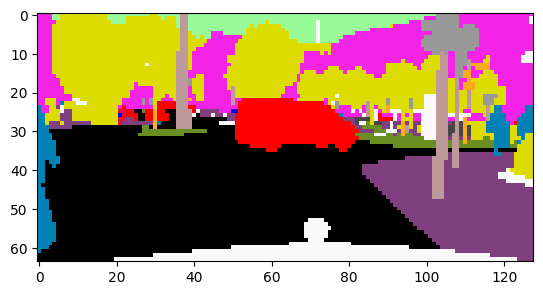

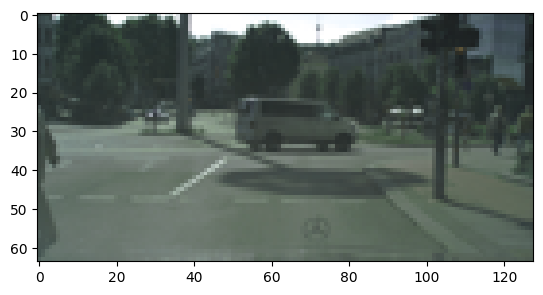

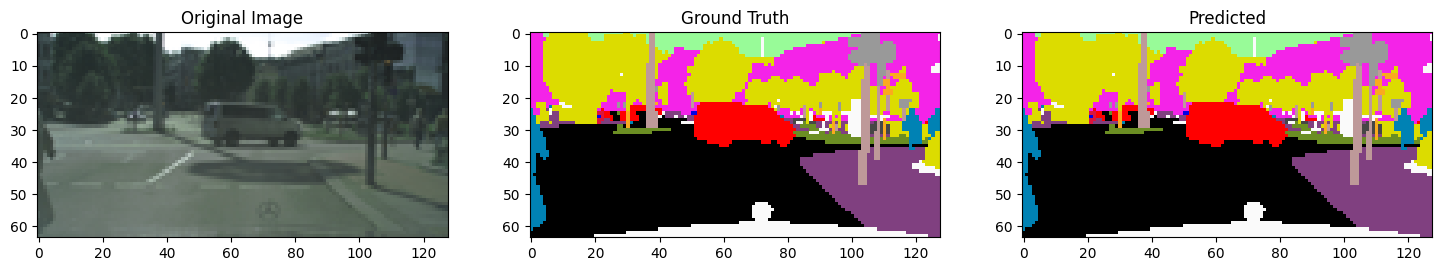

In [21]:
transform_imgs = transforms.Compose([transforms.Normalize(-1, 2),
                                    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                                     transforms.Normalize(0.5,0.5),])

train_dataset = CityscapesDownsampled(img_path="./resized_cityscapes/imgs_train.pth",label_path="./resized_cityscapes/labels_train.pth",
                                      transform=transform_imgs)

val_dataset = CityscapesDownsampled(img_path="./resized_cityscapes/imgs_val.pth",label_path="./resized_cityscapes/labels_val.pth")

test_dataset = CityscapesDownsampled(img_path="./resized_cityscapes/imgs_test.pth",label_path="./resized_cityscapes/labels_test.pth")

def test_data_loading(train_dataset):
    img, seg = train_dataset[0]
    _, seg2 = train_dataset[1]
    print(img.shape, seg.shape)
    assert img.shape[1:] == seg.shape
    print(img.dtype, seg.dtype, img.min(), img.max(), seg.min(), seg.max())
    # how to visualize seg maps
    train_dataset.seg_show(seg)
    plt.figure()
    # how to visualize images
    train_dataset.img_show(img, mean=torch.tensor([0.5]), std=torch.tensor([0.5]))
    # how to visualize triples
    # note: predicted would be the output of our unet
    train_dataset.plot_triplet(img, seg, seg)
    plt.show()

print("Train dataset size: ", len(train_dataset), "Val dataset size: ", len(val_dataset), "Test dataset size: ", len(test_dataset))
test_data_loading(train_dataset)

## Part IV. Training and Validation

With the data prepared and a model ready to be trained, all that is left is some training and validation code. As usual, we start with the validation function because we use it in the training function.

**Task:** Implement the `validate` function below. It takes in the model and a validation data loader, computes the loss and an evaluation metric for all examples in the loader and returns the mean loss and metric results (mean per example).

In [22]:
def validate(model, val_loader, device, criterion, metric):
    loss_step, metric_step = [], []
    ### START CODE HERE ### (approx. 11 lines)
    model.eval()

    with torch.no_grad():
        for inp_data, labels in val_loader:
            # Move imgs and labels to gpu
            labels = labels.to(device)
            inp_data = inp_data.to(device)
            # Forward pass
            outputs = model(inp_data)
            # Calculate and record loss and metrics
            metric_step.append(metric(outputs, labels).item())
            loss_step.append(criterion(outputs, labels).item())

    val_loss_epoch = np.mean(loss_step)
    val_metric = np.mean(metric_step)
    ### END CODE HERE ###
    return val_loss_epoch, val_metric

**Task:** Next up is the `train_one_epoch` function which implements the training loop for one pass over the entire loader. Compute and return the mean loss and mean metric (mean per example).

In [23]:
def train_one_epoch(model, optimizer, train_loader, device, criterion, metric):
    loss_step, metric_step = [], []
    ### START CODE HERE ### (approx. 11 lines)
    model.train()
    for (inp_data, labels) in train_loader:
        # Move imgs and labels to gpu
        labels = labels.to(device)
        inp_data = inp_data.to(device)
        # Forward pass
        outputs = model(inp_data)
        loss = criterion(outputs, labels)
        # Compute gradients and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Compute and record metric and loss
        metric_step.append(metric(outputs, labels).item())
        loss_step.append(loss.item())

    loss_curr_epoch = np.mean(loss_step)
    train_metric = np.mean(metric_step)
    ### END CODE HERE ###
    return loss_curr_epoch, train_metric

For visualization during training, we want to plot an input image, the resulting prediction and corresponding target. Implement the function `show_preds`, so that it

- Takes min(bs, num_samples) samples.
- Converts the class scores into concrete predictions for all pixels.
- Removes pixels in the prediction, which have the `ignore_index` in the target, i.e. set them to the `ignore_index` as well.



#### What is the `ignore_index=250`?
During the image annotation process, not all pixels are assigned one of the 19 classes. Therese are pixels belo to the `unlabeleed` class and have the annotation 250 in the segmentation maps. We only want to train with pixels that have a label from 0 to 19. The choice of the ignore_index value (here 250) is arbitary. Read the documentation of cross entropy understand how you can compute the loss while ignoring these pixel values.   


In [24]:
def show_preds(model, loader, device, ignore_index=250, num_samples=1):
    ### START CODE HERE ### (approx. 11 lines)
    model.eval()
    model = model.to(device)
    imgs, segs = next(iter(loader))
    preds = model(imgs.to(device))
    num_samples = min(num_samples, int(imgs.shape[0]))
    for img_id in range(num_samples):
        pred = preds.argmax(dim=1)[img_id].cpu()
        img, seg = imgs[img_id], segs[img_id]
        pred[seg==ignore_index] = ignore_index
        ### END CODE HERE ###
        loader.dataset.plot_triplet(img, seg, pred)  # Visualizes the three arguments in a plot

Finally, we put it all together in the `train` function. We are saving the best model, by best metric performance, for later evaluation.

**Task:**  Call the `train_one_epoch` and `validate` functions correctly to complete the function below.

In [25]:
def train(model, optimizer, num_epochs, train_loader, val_loader, device, criterion, metric, exp_name='unet', viz=False, viz_freq=20):
    best_val_metric = -1
    model = model.to(device)
    dict_log = {"train_metric":[], "val_metric":[], "train_loss":[], "val_loss":[]}
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        ### START CODE HERE ### (approx. 11 lines)
        train_loss, train_metric = train_one_epoch(model, optimizer, train_loader, device, criterion, metric)
        val_loss, val_metric,  = validate(model, val_loader, device, criterion, metric)
        ### END CODE HERE ###
        msg = (f'Ep {epoch}/{num_epochs}: metric : Train:{train_metric:.3f} \t Val:{val_metric:.2f}\
                || Loss: Train {train_loss:.3f} \t Val {val_loss:.3f}')

        pbar.set_description(msg)

        dict_log["train_metric"].append(train_metric)
        dict_log["val_metric"].append(val_metric)
        dict_log["train_loss"].append(train_loss)
        dict_log["val_loss"].append(val_loss)

        if val_metric > best_val_metric:
            best_val_metric = val_metric
            torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': val_loss,
                  'metric':val_metric,
                  }, f'{exp_name}_best_model_min_val_loss.pth')
        if viz and (epoch+1) % viz_freq==0:
            show_preds(model, train_loader, device, num_samples=1)

    return dict_log

## Part V. Training Preparations: Model testing and design

### Test the model on a small subset of the data

- Define a U-Net. Model parameters are irrelevant at this point.
- Use `utils.CityscapesSubset` defined in utils.py to make a subset containing the first 16 training and 16 validation samples.
- Define the dataloaders (batch_size 16).
- Perform a forward pass on the train subset dataloader.
- Visualize the triple (img, seg, prediction) of 3 samples in the batch (using `show_preds`)
- Compute the mean intesection over union (mIoU), and the cross entropy.


16 16
mIoU %: 0.7442319765686989
Cross-entropy loss 3.0887668132781982
torch.Size([64, 128]) torch.Size([3, 64, 128]) torch.Size([64, 128]) tensor(-0.9294) tensor(1.) tensor(0) tensor(250)


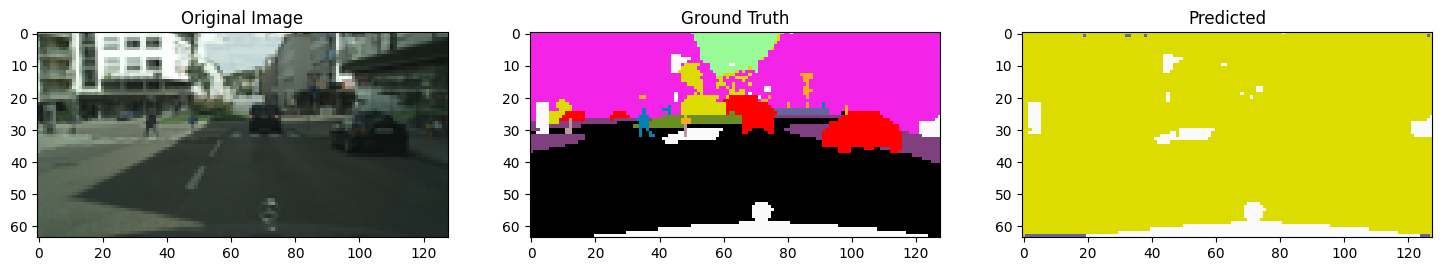

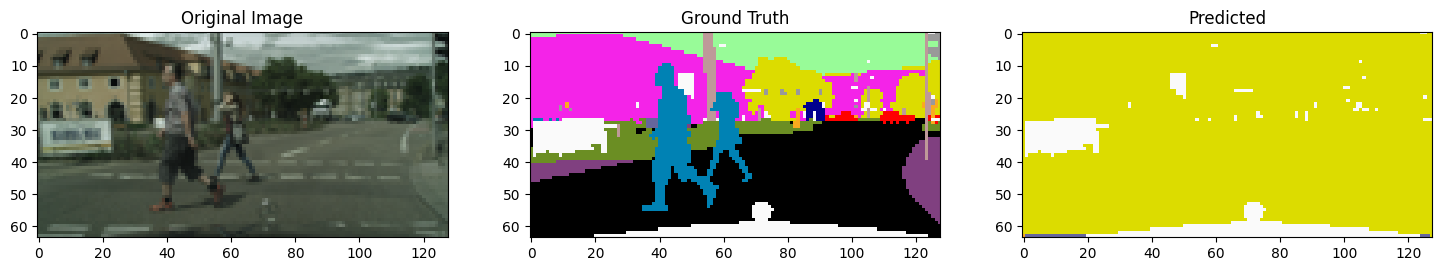

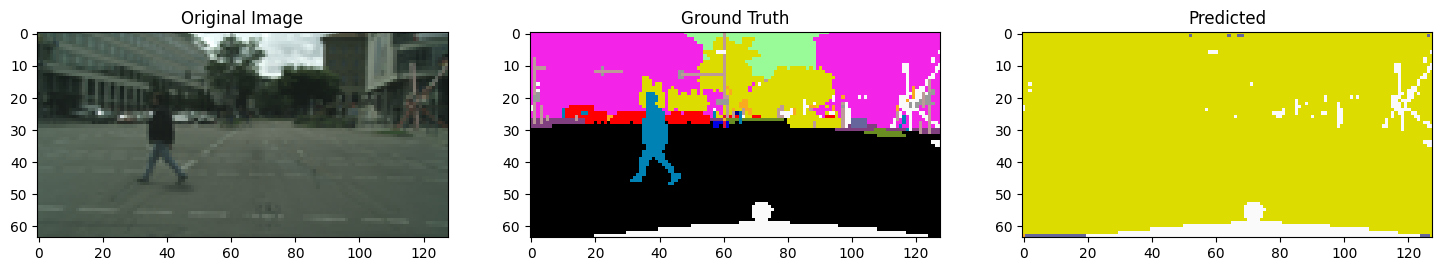

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### START CODE HERE ### (approx. 16-17 lines)
train_dataset_test = CityscapesSubset(train_dataset, list(range(16)), img_path="./resized_cityscapes/imgs_train.pth", label_path="./resized_cityscapes/labels_train.pth" )
val_dataset_test = CityscapesSubset(val_dataset, list(range(16)), img_path="./resized_cityscapes/imgs_val.pth", label_path="./resized_cityscapes/labels_val.pth" )

train_loader_test = DataLoader(
    train_dataset_test,
    batch_size = 16,
    shuffle=True,
    num_workers = 2,
    pin_memory = True)

val_loader_test = DataLoader(
    val_dataset_test,
    batch_size = 16,
    shuffle=False,
    num_workers = 1)

print(len(train_dataset_test), len(val_dataset_test))

model = UNet(resolution=128, in_channels=3, out_channels=19,
             base_channels=4, channel_mult=[1,1], num_blocks=3)

imgs, segs = next(iter(train_loader_test))
preds  = model(imgs)

# Compute mIoU
metric = iou(num_classes=19, ignore_index=ignore_index)
print("mIoU %:", metric(preds,segs).item()*100)

# Compute cross-entropy loss
criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)
print("Cross-entropy loss",criterion(preds,segs).item())

# How to visualize the predictions
img_id = 5
pred = preds.argmax(dim=1)[img_id,...]
img, seg = imgs[img_id,...], segs[img_id,...]
print(pred.shape, img.shape, seg.shape, img.min(), img.max(), seg.min(), seg.max())
show_preds(model, train_loader_test, device, num_samples=3)
### END CODE HERE ###

**Expected results**

Since we rely on random init, results may vary here.
You can cross-check the outcome of cross entropy, for instance, for a random guess in an N-class classification problem.
```
mIoU: 1.2005233205854893
Cross-entropy loss 3.0224854946136475
```
![im2](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a10_unet/figs/exp_out_viz.png)

# Part VI: Model design: Overfitting a small subset of data - design the basic structure of the UNet model

In this part, we will design the model's parameters, by overfitting a small subset of the data.

Assumption: A model that is able to score better performance metrics in the tiny subset would be better in the full dataset.
This assumption is used all across the academia and industry.

In this, way you can iterate over training the model multiple times.

**Task:**

- Choose the U-Net parameters and initialise a model.
- Train on the 16-examples subset for 200 epochs, with an optimizer of your choice.
- The training needs the CrossEntropy-Loss, for comparison between models you can use a metric of your choice.
- Tune the parameters to achieve better results.
- If you can, use the `summary` function here to keep track of your models design.
- Save the best model setup in a dictionary `best_setup`, where a parameter's name is the key.

Remember that the goal here is to overfit! You won't be able to prevent overfitting, since we have such few training examples, so don't worry if the validation accuracy stays very bad.

Normally, this step should strictly require less than 15 minutes. **Warning**: use the subsets of the train and val data!

Take the UNet with the best setup in terms of `base_channels`, `channel_mult`, `num_blocks`.





Note: Use `plot_stats(dict_log, title="./figs/foo", scale_metric=100, baseline=45)` to plot the results. During Overfitting a small subset of data the baseline mIoU is on the traindata (70%) while during the full experiment with the whole dataset the basline is the validation mIoU of 45%

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Identity-1           [-1, 3, 128, 64]               0
            Conv2d-2         [-1, 128, 128, 64]           3,584
            Conv2d-3         [-1, 128, 128, 64]               0
       BatchNorm2d-4         [-1, 128, 128, 64]             256
          Identity-5         [-1, 128, 128, 64]               0
            Conv2d-6         [-1, 128, 128, 64]         147,584
            Conv2d-7         [-1, 128, 128, 64]               0
       BatchNorm2d-8         [-1, 128, 128, 64]             256
          Identity-9         [-1, 128, 128, 64]               0
           Conv2d-10         [-1, 128, 128, 64]         147,584
           Conv2d-11         [-1, 128, 128, 64]               0
        UNetBlock-12         [-1, 128, 128, 64]               0
      BatchNorm2d-13         [-1, 128, 128, 64]             256
        MaxPool2d-14          [-1, 128,

Ep 199/200: metric : Train:0.828 	 Val:0.18                || Loss: Train 0.074 	 Val 1.545: 100%|██████████| 200/200 [04:47<00:00,  1.44s/it]


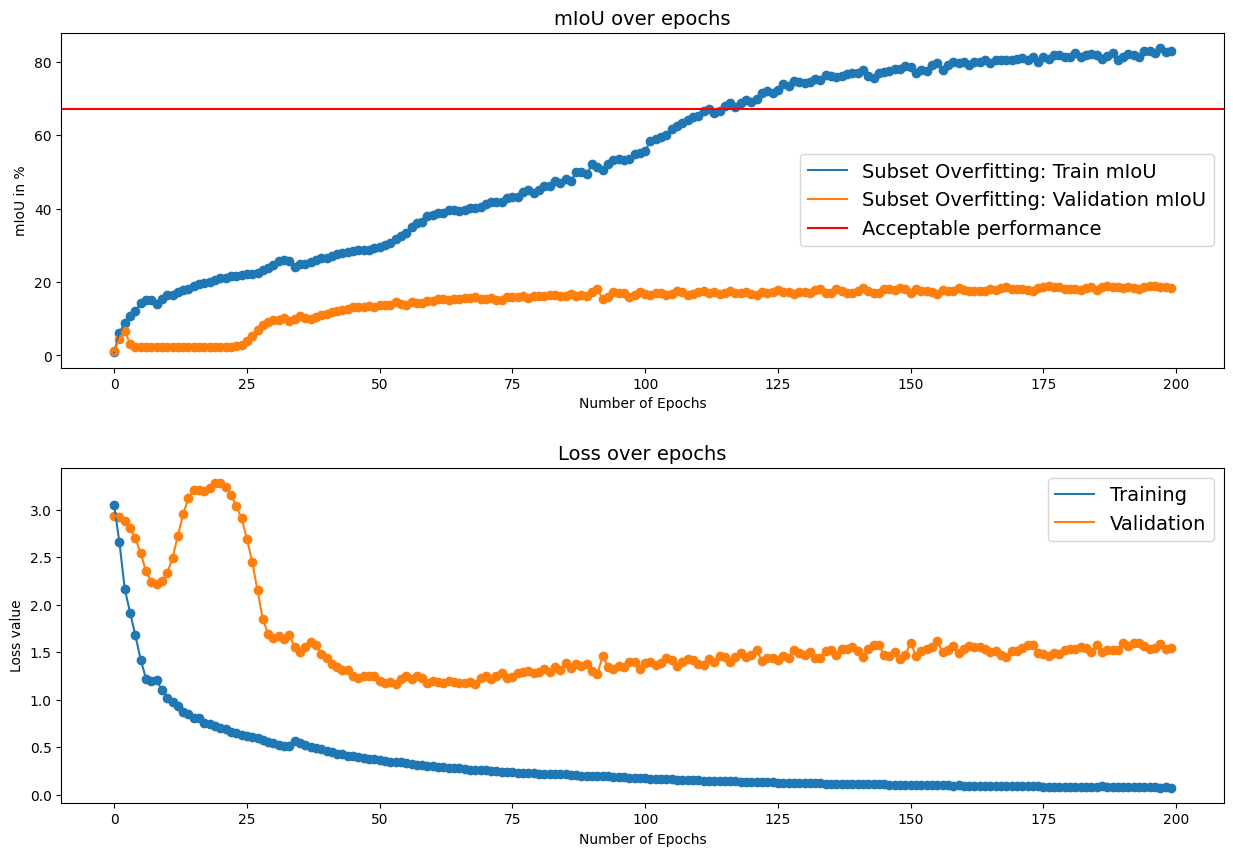

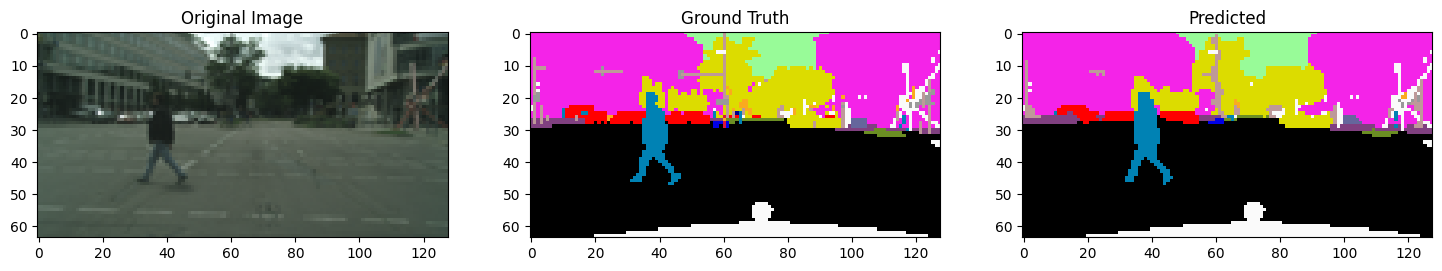

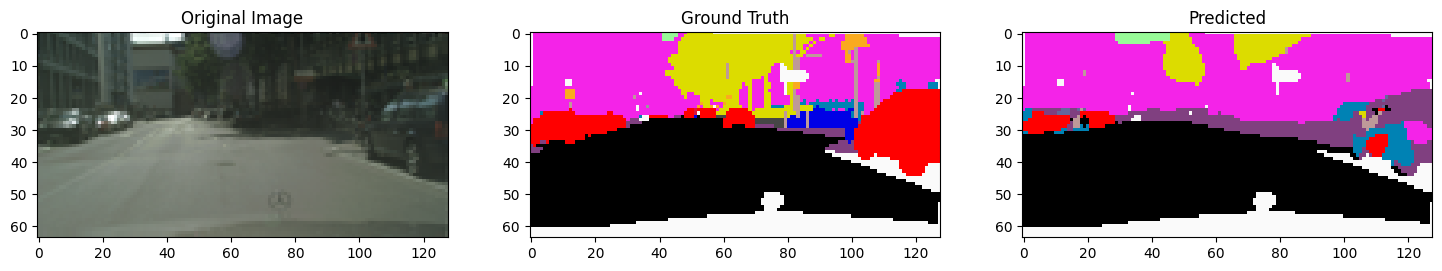

In [29]:
### START CODE HERE ### (approx. 11 lines)
model = UNet(resolution=128, in_channels=3, out_channels=19, \
             base_channels=128, channel_mult=[1,2,4], num_blocks=1)

optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)
metric = iou(num_classes=19, ignore_index=ignore_index).to(device)
epochs = 200
summary(model, input_size=(3,128,64), device='cpu')
dict_log = train(model, optimizer, epochs, train_loader_test, val_loader_test, device, criterion, metric, exp_name='UNet-ce-ovefit')
plot_stats(dict_log, modelname="Subset Overfitting:", baseline=67, scale_metric=100, title="./figs/so")
show_preds(model, train_loader_test, device, num_samples=1)
show_preds(model, val_loader_test, device, num_samples=1)
### END CODE HERE ###

**Expected results**

![im6](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a10_unet/figs/subset_overfitting.png)

# Part VII: Train the UNet with the CE loss

- Initialise a model with your best hyperparameter setup from before. You can use your dictionary as keyword arguments here with the `**` syntax.
- Use CrossEntropy as your loss function.
- Use the full dataset!

In [30]:
### START CODE HERE ### (approx. 5 lines)
best_setup = {"resolution": 128, "in_channels": 3, "out_channels": 19,
              "base_channels": 128, "channel_mult": [1,2,4], "num_blocks": 1}

train_loader = DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle=True,
    num_workers = 4,
    pin_memory = True)

val_loader = DataLoader(
    val_dataset,
    batch_size = 32,
    shuffle=False,
    num_workers = 2)
device = "cuda"
metric = iou(num_classes=19, ignore_index=ignore_index).to(device)
### END CODE HERE ###

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Notes:


- Time to execute for our unet: ~30mins
- VRAM: 11GB for batch size 32

Feel free to train for more epochs if you have the time!


Ep 99/100: metric : Train:0.734 	 Val:0.47                || Loss: Train 0.115 	 Val 0.386: 100%|██████████| 100/100 [2:42:33<00:00, 97.53s/it]


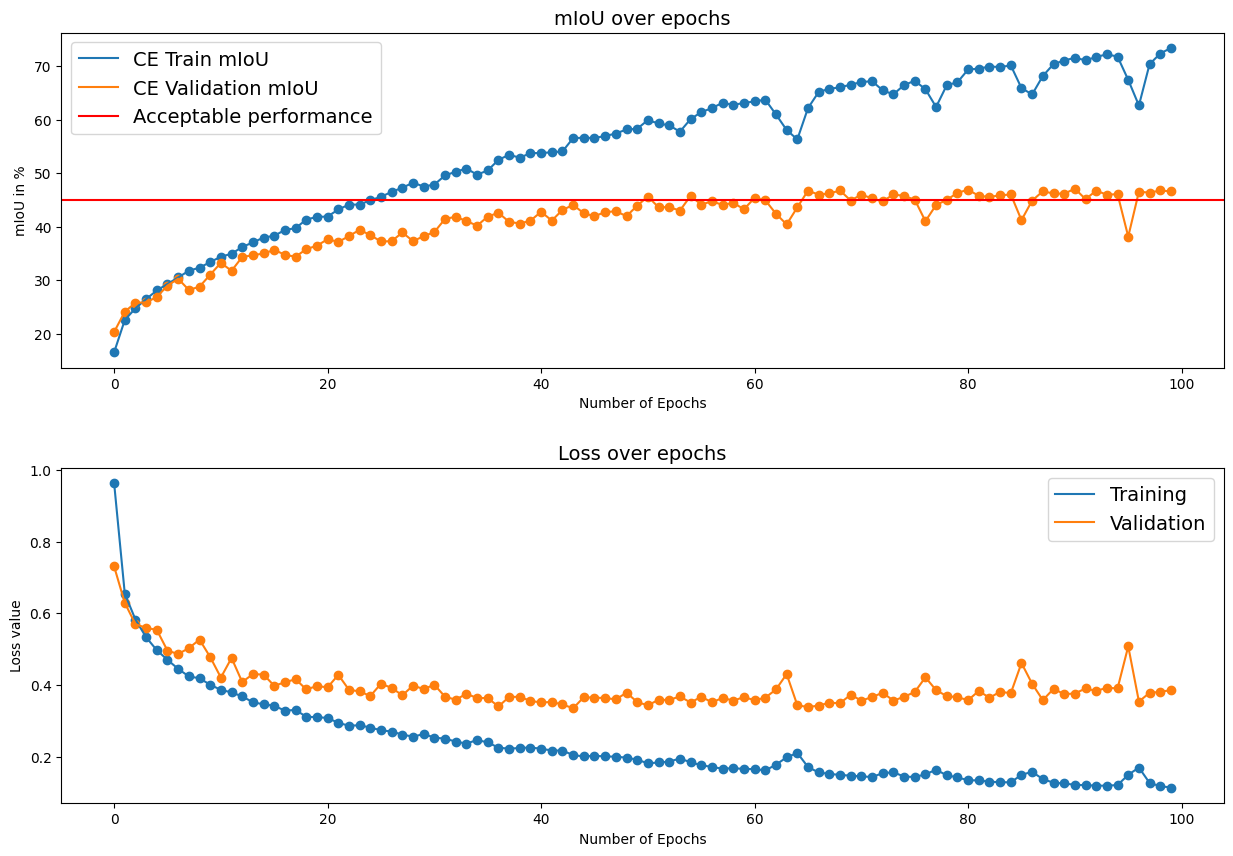

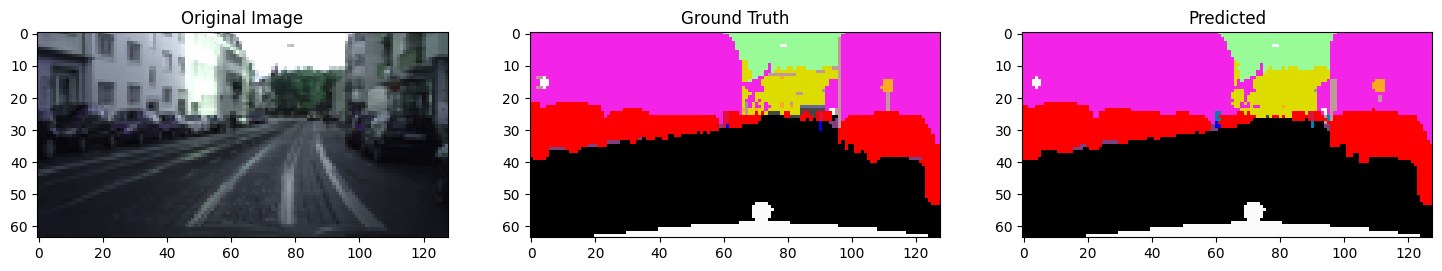

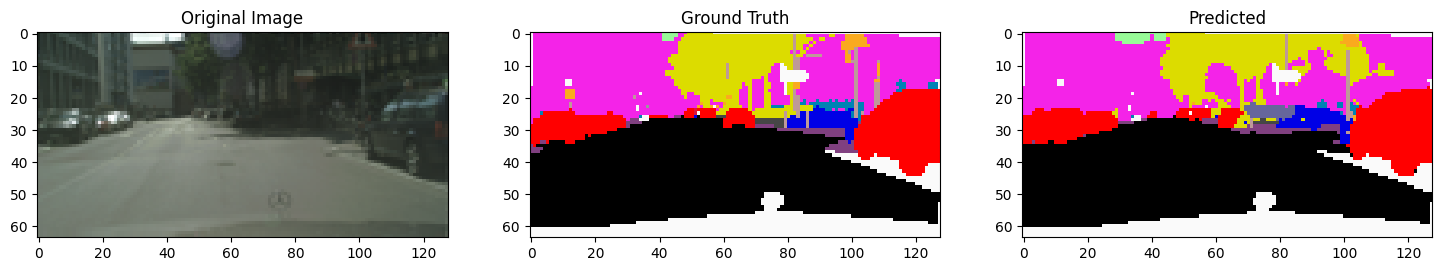

In [31]:
### START CODE HERE ### (approx. 3 lines)
model = UNet(**best_setup)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)
### END CODE HERE ###
dict_log = train(model, optimizer, 25, train_loader, val_loader, device, criterion, metric, exp_name='UNet-ce-pool')
plot_stats(dict_log, modelname="CE", title="./figs/unet_base", scale_metric=100, baseline=45)
show_preds(model, train_loader, device, num_samples=1)
show_preds(model, val_loader, device, num_samples=1)


### Expected result

![im7](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a10_unet/figs/unet_pool_upsampling_ce.png)

# Part VIII (OPTIONAL). Train the U-Net with strided convolutions (down) and transpose convolutions (up)

#### Downsampling:
Strided convolutions can be used as an alternative of pooling + conv.    

#### Upsampling:
Interpolation VS transpose convolution. As stated in [FCN](https://arxiv.org/pdf/1411.4038.pdf) :  
Simple bilinear interpolation computes each output pixel from the nearest four inputs by a linear map that depends only on the relative positions of the input and output cells. In a sense, upsampling with factor f is convolution with a fractional input stride of 1/f . So long as f is integral, a
natural way to upsample is therefore backwards convolution (sometimes called deconvolution or transpose convolution) with an output stride of f . Such an operation is trivial to implement, since it simply reverses the forward and backward passes of convolution.

---

The originally proposed [Unet](https://arxiv.org/abs/1505.04597) used max pooling and bilinear upsampling. What works best depends on the application. In image generation, for instance, we often use strided convolutions for downsampling and transpose convolutions for upsampling.


**Task:** Modify the `Conv2d` class, so that it supports transposed convolutions for up-sampling and an `nn.Conv2d` with `stride` 2 and `kernel_size` 2 (strided convolution) for downsampling. Then train the U-Net with those two options enabled. The finished `Conv2d` class should fulfill 3 cases as follows:


- **Regular case:** This class becomes a regular `nn.Conv2d` layer using its argument for `kernel`. Think about the appropriate amount of `padding` here.
- **Down-sampling case:** There are two options for down-sampling, depending on the `pooling` argument:
    - `pooling=True`: This class becomes a series of a `nn.MaxPool2d` layer using `kernel_size=2` and a `nn.Conv2d`.
    - `pooling=False`:  This class becomes a `nn.Conv2d` layer using `stride=2`.
- **Up-sampling case:** There are two options for up-sampling, depending on the `bilinear` argument:
    - `bilinear=True`: This class becomse a series of a `nn.Upsample` layer with `scale_factor=2`, `mode='bilinear'` and `align_corners=True`, and a `nn.Conv2d` layer using `kernel_size=3` and `padding=1`.
    - `bilinear=False`: This class becomes a `nn.ConvTransposed2d` layer with `kernel_size=2` and `stride=2`.



### Additional resource UNets, convolution arithmetic and image segmentation can be found in the links below:     


- [In CNN, are upsampling and transpose convolution the same?](https://stats.stackexchange.com/questions/252810/in-cnn-are-upsampling-and-transpose-convolution-the-same)
- [STRIVING FOR SIMPLICITY:
THE ALL CONVOLUTIONAL NET](https://arxiv.org/pdf/1412.6806.pdf)
- [Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)
- [An overview of Unet architectures for semantic segmentation and biomedical image segmentation](https://theaisummer.com/unet-architectures/)
- [Introduction to Strided Convolutions](https://www.geeksforgeeks.org/ml-introduction-to-strided-convolutions/)
- [A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)




In [ ]:
### START CODE HERE ### (approx. 6 lines)
model = UNet(**best_setup, bilinear=False, pooling=False)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)
dict_log = train(model, optimizer, 100, train_loader, val_loader, device, criterion, metric, exp_name='UNet-strided-transp-conv')
plot_stats(dict_log, modelname="Strided/transp Conv", title="./figs/unet_strid-conv", scale_metric=100, baseline=45)
show_preds(model, train_loader, device, num_samples=1)
show_preds(model, val_loader, device, num_samples=1)
### END CODE HERE ###

**Expected results**

![im8](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a10_unet/figs/UNet-strided-transp-conv.png)








